In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gzip
import json
import time
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#@title Utils functions
sns.set_theme(style="whitegrid")

def get_progress_bar(value, total, len=20):
  progress = value * len // total
  remaining = len - progress
  progress_str = "=" * progress
  remaining_str = " " * remaining
  return "[" + progress_str + remaining_str + "]"

from sklearn.model_selection import GridSearchCV

class AdvancedGridSearch():

  def __init__(self, X, y, cv, scoring="accuracy"):
    self.X = X
    self.y = y
    self.cv = cv

    self.scoring = scoring

    self.models = {}
    self.scores = {}

  def set_X(self, X):
    self.X = X
  
  def set_y(self, y):
    self.y = y

  def set_data(self, X, y):
    self.set_X(X)
    self.set_y(y)

  def fit(self, model_name, model, parameters, verbose=100, show_results=False):
    start = time.time()

    gs = GridSearchCV(model, parameters, verbose=verbose, return_train_score=True, n_jobs=-1, cv=self.cv, scoring=self.scoring)
    gs.fit(self.X, self.y)

    train_score = gs.cv_results_["mean_train_score"][gs.best_index_]
    validate_score = gs.cv_results_["mean_test_score"][gs.best_index_]

    print()
    print("[{}] Grid search completed in {:.3f} sec".format(model_name, time.time() - start))
    print("[{}] Best params: {}".format(model_name, gs.best_params_))
    print("[{}] Train Score: {:.3f}".format(model_name, train_score))
    print("[{}] Validate Score: {:.3f}".format(model_name, validate_score))
    
    if show_results:
      print()
      display(pd.DataFrame(gs.cv_results_).sort_values(by="rank_test_score").round(3).head(10))
    
    self.models[model_name] = gs.best_estimator_
    self.scores[model_name] = (train_score, validate_score)

## Read Dataset

In [ ]:
#@title Download dataset
from google_drive_downloader import GoogleDriveDownloader as gdd
import os
if not os.path.isfile("/content/Electronics_5.json.gz"):
  gdd.download_file_from_google_drive(file_id="1jMbNaArxVuF0ooSNYIWzghqGmAjt3t7f", dest_path="/content/Electronics_5.json.gz", unzip=False)
else:
  print("Dataset alreay downloaded.")

In [ ]:
#@title Load dataset
SIZE = 1_000_000 #@param

def parse(path, n):
  g = gzip.open(path, "rb")
  for i in range(n):
    yield json.loads(next(g))

def read_dataset(path, n=1e6):
  start = time.time()

  i = 0
  df = dict()

  for d in parse(path, n):
    df[i] = d
    i += 1

    # Progress bar
    if i % 100 == 0:
      progress_bar = get_progress_bar(i, n)
      percent = int(i/n * 100)
      print("\r%s%% %s Loading..." % (percent, progress_bar), end="")

  # Convertion into dataframe
  print("\r100%% %s Converting into dataframe..." % (get_progress_bar(n, n)), end="")
  result = pd.DataFrame.from_dict(df, orient="index")

  strtime = datetime.fromtimestamp(time.time() - start).strftime("%Mm %Ss")
  print("\r100%% %s Completed in %s" % (get_progress_bar(n, n), strtime))

  return result

df = read_dataset("Electronics_5.json.gz", n=SIZE)

100% [====================] Completed in 00m 37s


In [ ]:
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},D. C. Carrad,This is the best novel I have read in 2 or 3 y...,A star is born,937612800,NaN
1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},Evy,"Pages and pages of introspection, in the style...",A stream of consciousness novel,1382486400,NaN
2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},Kcorn,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600,NaN
3,5.0,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,{'Format:': ' Hardcover'},Caf Girl Writes,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,968025600,NaN
4,3.0,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,{'Format:': ' Hardcover'},W. Shane Schmidt,I was taken in by reviews that compared this b...,A dissenting view--In part.,949622400,NaN


# Handle missing data

In [ ]:
# Let's check how many records columns are empty
df.isna().sum()

overall                0
vote              804539
verified               0
reviewTime             0
reviewerID             0
asin                   0
style             484319
reviewerName         177
reviewText           103
summary               72
unixReviewTime         0
image             988515
dtype: int64

In [ ]:
# To handle missing votes, style and images, we are going to fill them with default values
df["vote"] = df["vote"].fillna(0)
df["style"] = df["style"].map(lambda x: x if type(x) == dict else {})
df["image"] = df["image"].map(lambda x: x if type(x) == list else [])

In [ ]:
# We are going to drop the remaining fields since there aren't too much records missing them
df = df[df["reviewText"].notna() & df["summary"].notna() & df["reviewerName"].notna()]

In [ ]:
# Let's check if everything is fine
df.isna().sum()

overall           0
vote              0
verified          0
reviewTime        0
reviewerID        0
asin              0
style             0
reviewerName      0
reviewText        0
summary           0
unixReviewTime    0
image             0
dtype: int64

In [ ]:
# Let's check with how many records we are left
len(df)

999653

# Convert data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999653 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         999653 non-null  float64
 1   vote            999653 non-null  object 
 2   verified        999653 non-null  bool   
 3   reviewTime      999653 non-null  object 
 4   reviewerID      999653 non-null  object 
 5   asin            999653 non-null  object 
 6   style           999653 non-null  object 
 7   reviewerName    999653 non-null  object 
 8   reviewText      999653 non-null  object 
 9   summary         999653 non-null  object 
 10  unixReviewTime  999653 non-null  int64  
 11  image           999653 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 92.5+ MB


In [ ]:
# Convert votes number format to integers, remove commas
df["vote"] = df["vote"].astype(str).str.replace(",", "").astype(int)
df["vote"].dtype

dtype('int64')

In [ ]:
# Convert dates to pandas date format
df["unixReviewTime"] = pd.to_datetime(df["unixReviewTime"], unit="s")
df["unixReviewTime"].dtype

dtype('<M8[ns]')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999653 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   overall         999653 non-null  float64       
 1   vote            999653 non-null  int64         
 2   verified        999653 non-null  bool          
 3   reviewTime      999653 non-null  object        
 4   reviewerID      999653 non-null  object        
 5   asin            999653 non-null  object        
 6   style           999653 non-null  object        
 7   reviewerName    999653 non-null  object        
 8   reviewText      999653 non-null  object        
 9   summary         999653 non-null  object        
 10  unixReviewTime  999653 non-null  datetime64[ns]
 11  image           999653 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 92.5+ MB


# Exploratory Data Analysis

## What are the most used words in review titles?

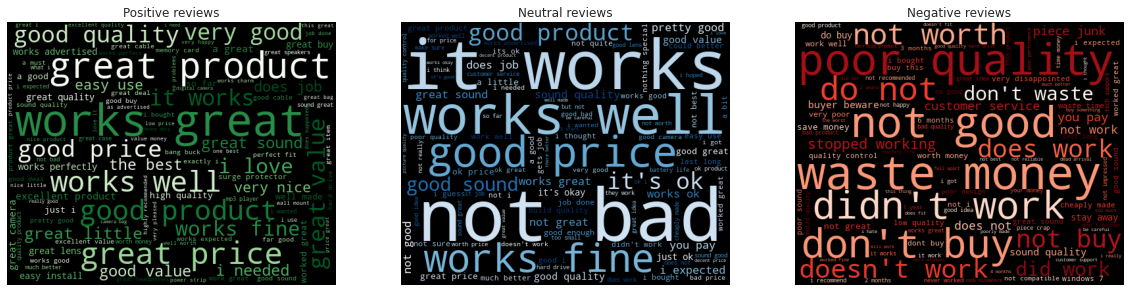

In [ ]:
import string
from wordcloud import WordCloud, STOPWORDS

def remove_punctuation(text, punct=string.punctuation):
  res = ""
  for c in text:
    if c not in punct:
      res += c
  return res

def extract_bigram_frequency(texts, stop_words):
  freqs = {}
  for summary in texts:
    summary = remove_punctuation(summary, set(string.punctuation) - {"'"})
    tokens = [token.lower() for token in summary.split(" ") if token not in string.punctuation and token not in stop_words]
    for i in range(1, len(tokens)):
      w1, w2 = tokens[i-1:i+1]
      key = w1 + " " + w2
      if key in stop_words:
        continue
      if key not in freqs:
        freqs[key] = 0
      freqs[key] += 1
  return freqs

stop_words = STOPWORDS.union({"one star", "two stars", "three stars", "four stars", "five stars"})
corpus = [
    ("Positive reviews", df[(df["overall"] >= 4.0)]["summary"], "Greens"),
    ("Neutral reviews", df[df["overall"] == 3.0]["summary"], "Blues"),
    ("Negative reviews", df[(df["overall"] <= 2.0)]["summary"], "Reds")
]

fig, axs = plt.subplots(1, 3, figsize=(20, 14))
for i in range(len(axs)):
  title, texts, cmap = corpus[i]
  freqs = extract_bigram_frequency(texts, stop_words)
  wc = WordCloud(height=400, width=500, colormap=cmap, max_words=100).generate_from_frequencies(freqs)
  axs[i].imshow(wc)
  axs[i].axis("off")
  axs[i].title.set_text(title)

## How long should be a review to be helpful?

In [ ]:
df["reviewLength"] = df["reviewText"].str.len()

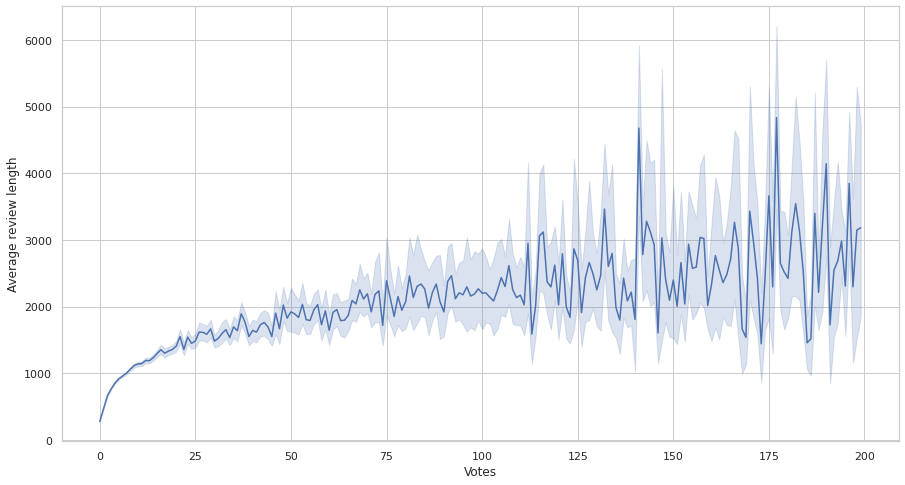

In [ ]:
df = df.sort_values("vote")
plt.figure(figsize=(15, 8))
sns.lineplot(data=df[df["vote"] < 200], x="vote", y="reviewLength")
plt.xlabel("Votes")
plt.ylabel("Average review length")
plt.show()

## Are images helpful for reviews?

In [ ]:
df["hasImages"] = df["image"].map(lambda x: int(len(x) > 0))

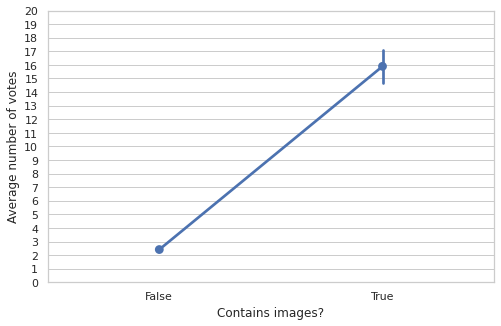

In [ ]:
plt.figure(figsize=(8, 5))
sns.pointplot(data=df, x="hasImages", y="vote")
plt.yticks(range(21))
plt.xticks(range(2), labels=["False", "True"])
plt.ylabel("Average number of votes")
plt.xlabel("Contains images?")
plt.show()

## How many reviews are posted per month?

In [ ]:
# Create new features for dates
df["day"] = df["unixReviewTime"].dt.day
df["month"] = df["unixReviewTime"].dt.month
df["year"] = df["unixReviewTime"].dt.year
df.head(5)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,reviewLength,hasImages,day,month,year
454629,5.0,0,True,"09 8, 2017",A1W6JMKDG77V8V,B000EZV3T8,{'Package Type:': ' Standard Packaging'},cominatyalive,Thought it was dead upon arrival but turned ou...,Nice Unit!,2017-09-08,[],105,0,8,9,2017
588059,5.0,0,True,"02 8, 2013",A4SOQCD2P0N0R,B000MX48VM,"{'Size:': ' 4 GB', 'Package Type:': ' Standard...",jumbo,i purchased this card a few years back and it ...,lasted over a year,2013-02-08,[],132,0,8,2,2013
588060,5.0,0,True,"02 7, 2013",A3G2AIJK60GDU2,B000MX48VM,"{'Size:': ' 32 GB', 'Package Type:': ' Standar...",Eric,I'd say this is a very good class 4 card. I w...,Good Performance for Class 4,2013-02-07,[],129,0,7,2,2013
588061,5.0,0,True,"02 7, 2013",A33DWKLYMM5TO2,B000MX48VM,"{'Size:': ' 8 GB', 'Package Type:': ' Frustrat...",MARCOS Y YOSIDA,Good Product. As expected. No compains. If you...,Good Product. As expected. No compains. If you...,2013-02-07,[],107,0,7,2,2013
588062,5.0,0,True,"02 5, 2013",A48B9P820380B,B000MX48VM,"{'Size:': ' 4 GB', 'Package Type:': ' Frustrat...",Geronimo Centeno,"Excelente, buen item, llego perfecto y en buen...",A++++++++++++++,2013-02-05,[],128,0,5,2,2013


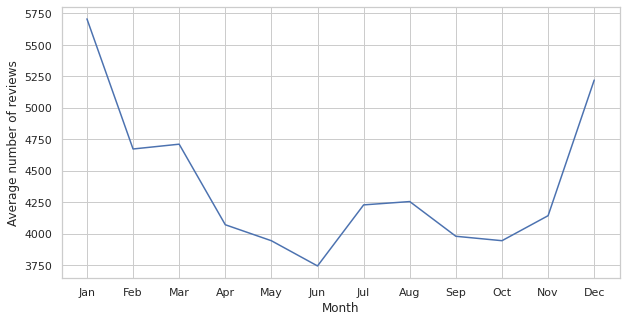

In [ ]:
data = df.groupby(["month", "year"]).size().groupby("month").mean()
plt.figure(figsize=(10, 5))
sns.lineplot(data=data)
plt.xticks(range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.ylabel("Average number of reviews")
plt.xlabel("Month")
plt.show()

## Are verified purchase-reviews more helpful?

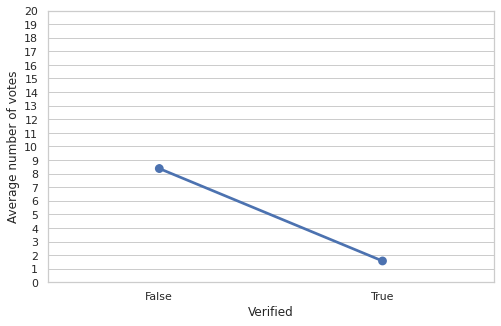

In [ ]:
plt.figure(figsize=(8, 5))
sns.pointplot(data=df, x="verified", y="vote")
plt.yticks(range(21))
plt.xticks(range(2), labels=["False", "True"])
plt.ylabel("Average number of votes")
plt.xlabel("Verified")
plt.show()

# Feature engineering

### Overall

In [ ]:
# Transform overall for feedback analysis
df["overall"] = df["overall"].map(lambda x: 0 if x < 3 else 1 if x == 3 else 2)
df["overall"].head(5)

454629    2
588059    2
588060    2
588061    2
588062    2
Name: overall, dtype: int64

## Anonymous users

In [ ]:
# Transform reviewerName to "Is user anonymous"
df["isUserAnonymous"] = df["reviewerName"].map(lambda name: 0 if name == "Amazon Customer" or name == "Kindle Customer" else 1)
df["isUserAnonymous"].head(5)

454629    1
588059    1
588060    1
588061    1
588062    1
Name: isUserAnonymous, dtype: int64

## Style

In [ ]:
# Transform style to "Has style"
df["hasStyle"] = df["style"].map(lambda style: 1 if style != {} else 0)
df["hasStyle"].head(5)

454629    1
588059    1
588060    1
588061    1
588062    1
Name: hasStyle, dtype: int64

## Verified

In [ ]:
# Transform verified boolean values to numbers
df["isVerified"] = df["verified"].replace([False, True], [0, 1])
df["isVerified"].head(5)

454629    1
588059    1
588060    1
588061    1
588062    1
Name: isVerified, dtype: int64

## Drop unused features

In [ ]:
df = df.drop(columns=["asin", "style", "reviewerID", "reviewTime", "unixReviewTime", "vote", "image", "verified", "reviewerName"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999653 entries, 454629 to 812502
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   overall          999653 non-null  int64 
 1   reviewText       999653 non-null  object
 2   summary          999653 non-null  object
 3   reviewLength     999653 non-null  int64 
 4   hasImages        999653 non-null  int64 
 5   day              999653 non-null  int64 
 6   month            999653 non-null  int64 
 7   year             999653 non-null  int64 
 8   isUserAnonymous  999653 non-null  int64 
 9   hasStyle         999653 non-null  int64 
 10  isVerified       999653 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 131.5+ MB


## Correlation Matrix

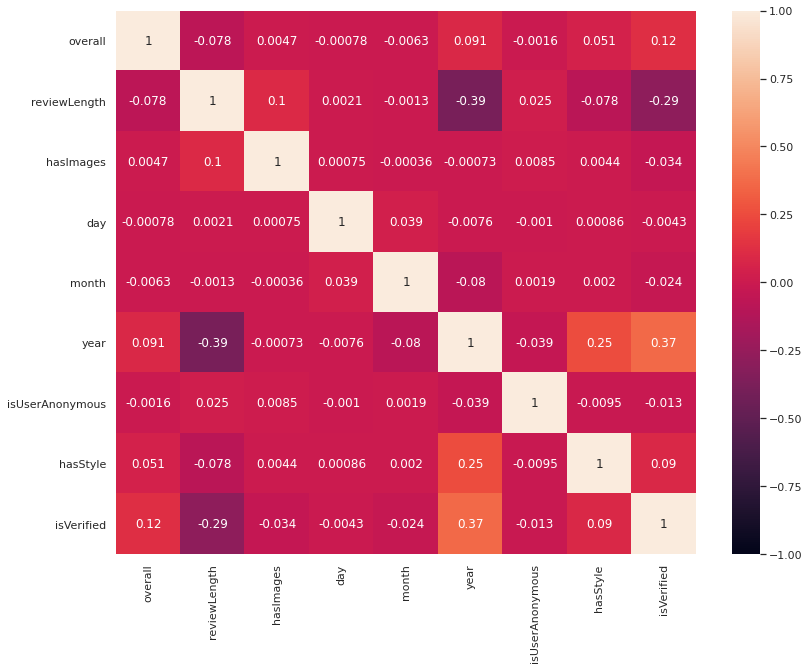

In [ ]:
plt.figure(figsize=(13, 10))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.yticks(rotation=0)
plt.show()

# Data preparation

In [ ]:
features = set(df.columns) - {"overall"}
X, y = df[features], df["overall"]
display(X)
display(pd.DataFrame(y))

,hasImages,reviewLength,summary,reviewText,day,month,isVerified,isUserAnonymous,hasStyle,year
454629,0,105,Nice Unit!,Thought it was dead upon arrival but turned ou...,8,9,1,1,1,2017
588059,0,132,lasted over a year,i purchased this card a few years back and it ...,8,2,1,1,1,2013
588060,0,129,Good Performance for Class 4,I'd say this is a very good class 4 card. I w...,7,2,1,1,1,2013
588061,0,107,Good Product. As expected. No compains. If you...,Good Product. As expected. No compains. If you...,7,2,1,1,1,2013
588062,0,128,A++++++++++++++,"Excelente, buen item, llego perfecto y en buen...",5,2,1,1,1,2013
...,...,...,...,...,...,...,...,...,...,...
649980,1,9637,BC-700/900/1000 FAQ,"[Update on April 4, 2012]\nMy original review ...",30,8,1,1,1,2007
127602,0,1809,"Sharp, fast, inexpensive",Once upon a time the 50 mm lens was THE standa...,10,4,0,1,1,2005
689569,0,6138,Ultra Flip Review and walkthrough,I'm a computer artist and animator and I haven...,16,9,0,1,1,2007
850190,0,3305,Garmin Nuvi 255w,I actually could not decide between the Garmin...,30,6,1,1,0,2008


,overall
454629,2
588059,2
588060,2
588061,2
588062,2
...,...
649980,2
127602,2
689569,2
850190,2


### Target distribution

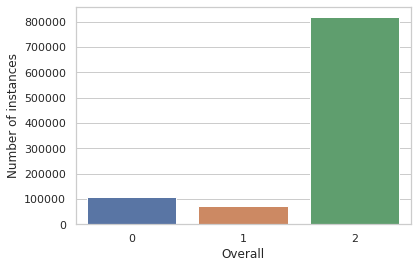

In [ ]:
sns.countplot(x="overall", data=df)
plt.xlabel("Overall")
plt.ylabel("Number of instances")
plt.show()

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Undersample the minority classes to balance them
undersample = RandomUnderSampler(random_state=42)

X_under, y_under = undersample.fit_resample(X, y)
X_under, y_under = pd.DataFrame(X_under, columns=X.columns), pd.Series(y_under, name=y.name)

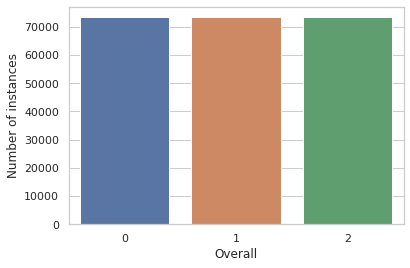

In [ ]:
sns.countplot(x=y_under)
plt.xlabel("Overall")
plt.ylabel("Number of instances")
plt.show()

In [ ]:
print("Number of instances:", len(X_under))

Number of instances: 220188


### Train/Validation/Test split

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.15, random_state=42)

cv = StratifiedShuffleSplit(n_splits=1, test_size=0.17, random_state=42)

In [ ]:
print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (187159, 10) (187159,)
Test: (33029, 10) (33029,)


# Text-free approach

In [ ]:
# Free RAM
import gc
gc.collect()

# Remove summary and reviewText
X_train_base = X_train.drop(["summary", "reviewText"], axis=1)
y_train_base = y_train
X_test_base = X_test.drop(["summary", "reviewText"], axis=1)
y_test_base = y_test

# Create grid search manager
ags_base = AdvancedGridSearch(X_train_base, y_train_base, cv)

X_train_base.head(10)

,isVerified,isUserAnonymous,hasStyle,year,month,reviewLength,day,hasImages
71137,1,1,1,2015,9,110,25,0
60608,1,1,1,2010,5,345,21,0
98962,1,1,1,2015,11,109,18,0
186651,1,1,0,2010,11,528,9,0
43350,1,1,1,2014,12,296,11,0
197673,0,1,0,2006,6,806,27,0
60248,1,1,0,2010,11,110,23,0
181376,1,1,1,2014,11,26,20,0
204602,1,1,0,2006,3,400,16,0
76927,1,1,0,2016,2,10,5,0


## Dummy Classifier

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline

model_name = "DummyClassifier"
pipeline = make_pipeline(DummyClassifier(random_state=42))

ags_base.fit(model_name, pipeline, {})

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished

[DummyClassifier] Grid search completed in 1.322 sec
[DummyClassifier] Best params: {}
[DummyClassifier] Train Score: 0.332
[DummyClassifier] Validate Score: 0.333


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

model_name = "LogisticRegression"
pipeline = make_pipeline(LogisticRegression(n_jobs=-1, random_state=42))

parameters = {"C": [.5, 1, 2, 5, 10], "solver": ["newton-cg", "lbfgs", "saga"], "max_iter": [50]}
new_params = {"logisticregression__" + key: parameters[key] for key in parameters}

ags_base.fit(model_name, pipeline, new_params, show_results=True)

Fitting 1 folds for each of 15 candidates, totalling 15 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  13 out of  15 | elapsed:  1.6min remaining:   15.0s
[Parallel(n_jobs=-1)]: Done  15 out of

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__max_iter,param_logisticregression__solver,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
9,32.945,0.0,0.020,0.0,5,50,newton-cg,"{'logisticregression__C': 5, 'logisticregressi...",0.406,0.406,0.0,1,0.402,0.402,0.0
12,26.370,0.0,0.012,0.0,10,50,newton-cg,"{'logisticregression__C': 10, 'logisticregress...",0.406,0.406,0.0,2,0.402,0.402,0.0
6,33.449,0.0,0.020,0.0,2,50,newton-cg,"{'logisticregression__C': 2, 'logisticregressi...",0.406,0.406,0.0,3,0.402,0.402,0.0
3,35.544,0.0,0.019,0.0,1,50,newton-cg,"{'logisticregression__C': 1, 'logisticregressi...",0.405,0.405,0.0,4,0.402,0.402,0.0
0,36.537,0.0,0.021,0.0,0.5,50,newton-cg,"{'logisticregression__C': 0.5, 'logisticregres...",0.404,0.404,0.0,5,0.402,0.402,0.0
4,4.197,0.0,0.020,0.0,1,50,lbfgs,"{'logisticregression__C': 1, 'logisticregressi...",0.390,0.390,0.0,6,0.388,0.388,0.0
7,4.282,0.0,0.019,0.0,2,50,lbfgs,"{'logisticregression__C': 2, 'logisticregressi...",0.390,0.390,0.0,6,0.388,0.388,0.0
10,4.287,0.0,0.035,0.0,5,50,lbfgs,"{'logisticregression__C': 5, 'logisticregressi...",0.390,0.390,0.0,6,0.388,0.388,0.0
13,4.198,0.0,0.020,0.0,10,50,lbfgs,"{'logisticregression__C': 10, 'logisticregress...",0.390,0.390,0.0,6,0.388,0.388,0.0
1,4.195,0.0,0.021,0.0,0.5,50,lbfgs,"{'logisticregression__C': 0.5, 'logisticregres...",0.390,0.390,0.0,10,0.388,0.388,0.0


## Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

model_name = "AdaBoostClassifier"
pipeline = make_pipeline(AdaBoostClassifier(random_state=42))

parameters = {"n_estimators": [25, 50, 100], "learning_rate": [.2, .5, 1, 2]}
new_params = {"adaboostclassifier__" + key: parameters[key] for key in parameters}

ags_base.fit(model_name, pipeline, new_params, show_results=True)

Fitting 1 folds for each of 12 candidates, totalling 12 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.8min remaining:   21.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.1min finished

[AdaBoostClassifier] Grid search completed in 145.856 sec
[AdaBoostClas

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_adaboostclassifier__learning_rate,param_adaboostclassifier__n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
5,23.399,0.0,1.939,0.0,0.5,100,"{'adaboostclassifier__learning_rate': 0.5, 'ad...",0.428,0.428,0.0,1,0.423,0.423,0.0
8,23.387,0.0,1.804,0.0,1,100,"{'adaboostclassifier__learning_rate': 1, 'adab...",0.427,0.427,0.0,2,0.423,0.423,0.0
2,23.271,0.0,1.843,0.0,0.2,100,"{'adaboostclassifier__learning_rate': 0.2, 'ad...",0.427,0.427,0.0,3,0.421,0.421,0.0
7,11.718,0.0,1.007,0.0,1,50,"{'adaboostclassifier__learning_rate': 1, 'adab...",0.426,0.426,0.0,4,0.422,0.422,0.0
4,11.701,0.0,0.938,0.0,0.5,50,"{'adaboostclassifier__learning_rate': 0.5, 'ad...",0.425,0.425,0.0,5,0.421,0.421,0.0
1,11.608,0.0,0.898,0.0,0.2,50,"{'adaboostclassifier__learning_rate': 0.2, 'ad...",0.425,0.425,0.0,6,0.419,0.419,0.0
6,5.871,0.0,0.454,0.0,1,25,"{'adaboostclassifier__learning_rate': 1, 'adab...",0.423,0.423,0.0,7,0.419,0.419,0.0
3,5.838,0.0,0.459,0.0,0.5,25,"{'adaboostclassifier__learning_rate': 0.5, 'ad...",0.422,0.422,0.0,8,0.418,0.418,0.0
0,5.880,0.0,0.470,0.0,0.2,25,"{'adaboostclassifier__learning_rate': 0.2, 'ad...",0.421,0.421,0.0,9,0.415,0.415,0.0
9,5.984,0.0,0.492,0.0,2,25,"{'adaboostclassifier__learning_rate': 2, 'adab...",0.406,0.406,0.0,10,0.402,0.402,0.0


## LinearSVM

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

model_name = "LinearSVM"
pipeline = make_pipeline(StandardScaler(), LinearSVC(random_state=42))

parameters = {"C": [.01, .1, 1, 10, 20]}
new_params = {"linearsvc__" + key: parameters[key] for key in parameters}

ags_base.fit(model_name, pipeline, new_params, show_results=True)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.4min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min finished

[LinearSVM] Grid search completed in 336.619 sec
[LinearSVM] Best params: {'linearsvc__C': 20}
[LinearSVM] Train Score: 0.401
[LinearSVM] Validate Score: 0.402



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linearsvc__C,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
4,115.503,0.0,0.013,0.0,20,{'linearsvc__C': 20},0.402,0.402,0.0,1,0.401,0.401,0.0
2,121.174,0.0,0.028,0.0,1,{'linearsvc__C': 1},0.402,0.402,0.0,2,0.399,0.399,0.0
0,20.090,0.0,0.022,0.0,0.01,{'linearsvc__C': 0.01},0.401,0.401,0.0,3,0.399,0.399,0.0
1,126.561,0.0,0.028,0.0,0.1,{'linearsvc__C': 0.1},0.401,0.401,0.0,4,0.399,0.399,0.0
3,122.371,0.0,0.023,0.0,10,{'linearsvc__C': 10},0.399,0.399,0.0,5,0.398,0.398,0.0


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_name = "RandomForest"
pipeline = make_pipeline(RandomForestClassifier(random_state=42, n_jobs=-1))

parameters = {"n_estimators": [50, 100, 200], "criterion": ["gini", "entropy"], "max_depth": [100], "min_samples_leaf": [1, 2, 5]}
new_params = {"randomforestclassifier__" + key: parameters[key] for key in parameters}

ags_base.fit(model_name, pipeline, new_params, show_results=True)

Fitting 1 folds for each of 18 candidates, totalling 18 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  5.

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__criterion,param_randomforestclassifier__max_depth,param_randomforestclassifier__min_samples_leaf,param_randomforestclassifier__n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
14,65.384,0.0,3.072,0.0,entropy,100,2,200,{'randomforestclassifier__criterion': 'entropy...,0.449,0.449,0.0,1,0.915,0.915,0.0
4,24.865,0.0,1.662,0.0,gini,100,2,100,"{'randomforestclassifier__criterion': 'gini', ...",0.446,0.446,0.0,2,0.911,0.911,0.0
5,46.382,0.0,2.757,0.0,gini,100,2,200,"{'randomforestclassifier__criterion': 'gini', ...",0.446,0.446,0.0,3,0.915,0.915,0.0
13,34.173,0.0,1.667,0.0,entropy,100,2,100,{'randomforestclassifier__criterion': 'entropy...,0.445,0.445,0.0,4,0.911,0.911,0.0
3,12.621,0.0,0.957,0.0,gini,100,2,50,"{'randomforestclassifier__criterion': 'gini', ...",0.443,0.443,0.0,5,0.901,0.901,0.0
12,16.821,0.0,0.860,0.0,entropy,100,2,50,{'randomforestclassifier__criterion': 'entropy...,0.442,0.442,0.0,6,0.900,0.900,0.0
11,76.541,0.0,3.774,0.0,entropy,100,1,200,{'randomforestclassifier__criterion': 'entropy...,0.442,0.442,0.0,6,0.987,0.987,0.0
10,39.194,0.0,1.870,0.0,entropy,100,1,100,{'randomforestclassifier__criterion': 'entropy...,0.442,0.442,0.0,8,0.987,0.987,0.0
17,41.544,0.0,1.218,0.0,entropy,100,5,200,{'randomforestclassifier__criterion': 'entropy...,0.440,0.440,0.0,9,0.717,0.717,0.0
2,54.774,0.0,3.766,0.0,gini,100,1,200,"{'randomforestclassifier__criterion': 'gini', ...",0.440,0.440,0.0,10,0.987,0.987,0.0


## MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

model_name = "MultiLayerPerceptor"
pipeline = make_pipeline(MinMaxScaler(), MLPClassifier(random_state=42))

parameters = {
    "hidden_layer_sizes": [(32), (32, 32), (32, 64)],
    "activation": ["relu"],
    "solver": ["adam"],
    "alpha": [0.0001, 0.001],
}
new_params = {"mlpclassifier__" + key: parameters[key] for key in parameters}

ags_base.fit(model_name, pipeline, new_params, show_results=True)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  3.4min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  4.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  4.8min finished

[MultiLayerPerceptor] Grid search completed in 423.686 sec
[MultiLayerPerceptor] Best params: {'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.0001, 'mlpclassifier__hidden_layer_sizes': (32, 64), 'mlpclassifier__solver': 'adam'}
[MultiLayerPerceptor] Train Score: 0.427
[MultiLayerPerceptor] Validate Score: 0.425



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlpclassifier__activation,param_mlpclassifier__alpha,param_mlpclassifier__hidden_layer_sizes,param_mlpclassifier__solver,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
2,165.532,0.0,0.198,0.0,relu,0.0001,"(32, 64)",adam,"{'mlpclassifier__activation': 'relu', 'mlpclas...",0.425,0.425,0.0,1,0.427,0.427,0.0
4,88.298,0.0,0.132,0.0,relu,0.001,"(32, 32)",adam,"{'mlpclassifier__activation': 'relu', 'mlpclas...",0.425,0.425,0.0,2,0.423,0.423,0.0
5,78.061,0.0,0.191,0.0,relu,0.001,"(32, 64)",adam,"{'mlpclassifier__activation': 'relu', 'mlpclas...",0.424,0.424,0.0,3,0.421,0.421,0.0
1,86.987,0.0,0.105,0.0,relu,0.0001,"(32, 32)",adam,"{'mlpclassifier__activation': 'relu', 'mlpclas...",0.423,0.423,0.0,4,0.423,0.423,0.0
0,38.479,0.0,0.042,0.0,relu,0.0001,32,adam,"{'mlpclassifier__activation': 'relu', 'mlpclas...",0.423,0.423,0.0,5,0.420,0.420,0.0
3,35.470,0.0,0.042,0.0,relu,0.001,32,adam,"{'mlpclassifier__activation': 'relu', 'mlpclas...",0.423,0.423,0.0,6,0.419,0.419,0.0


## Testing and Evaluation

In [ ]:
columns = ["Train Accuracy score", "Validate Accuracy score"]
df_scores = pd.DataFrame(ags_base.scores.values(), index=ags_base.scores.keys(), columns=columns)
df_scores = df_scores.sort_values("Validate Accuracy score", ascending=False)
df_scores

,Train Accuracy score,Validate Accuracy score
RandomForest,0.914633,0.449085
AdaBoostClassifier,0.423359,0.427965
MultiLayerPerceptor,0.426764,0.425231
LogisticRegression,0.401980,0.405839
LinearSVM,0.401002,0.401974
DummyClassifier,0.332115,0.333365


In [ ]:
max_score = df_scores["Validate Accuracy score"].max()
best_model_name = df_scores[df_scores["Validate Accuracy score"] == max_score].index[0]
best_model = ags_base.models[best_model_name]
print("The best model is the {} with {} of accuracy on the validation set".format(best_model_name, round(max_score, 3)))

The best model is the RandomForest with 0.449 of accuracy on the validation set


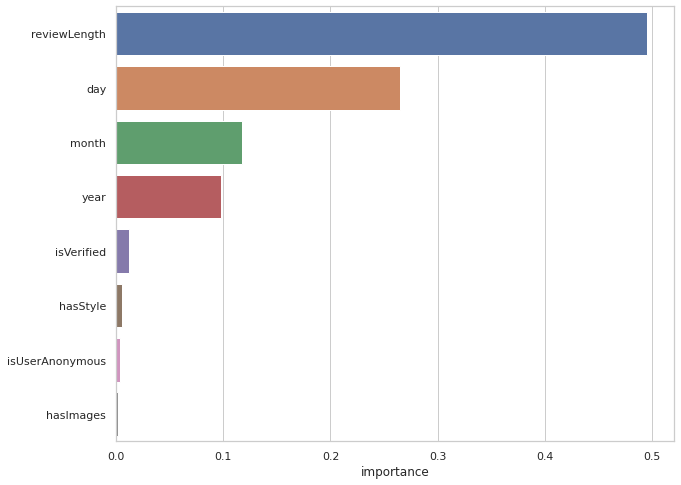

In [ ]:
importances = pd.DataFrame(np.zeros((X_train_base.shape[1], 1)), columns=["importance"], index=X_train_base.columns)

rfc = best_model.named_steps["randomforestclassifier"]
importances.iloc[:,0] = rfc.feature_importances_

importances = importances.sort_values(by="importance", ascending=False)[:30]

plt.figure(figsize=(10, 8))
sns.barplot(x="importance", y=importances.index, data=importances)
plt.show()

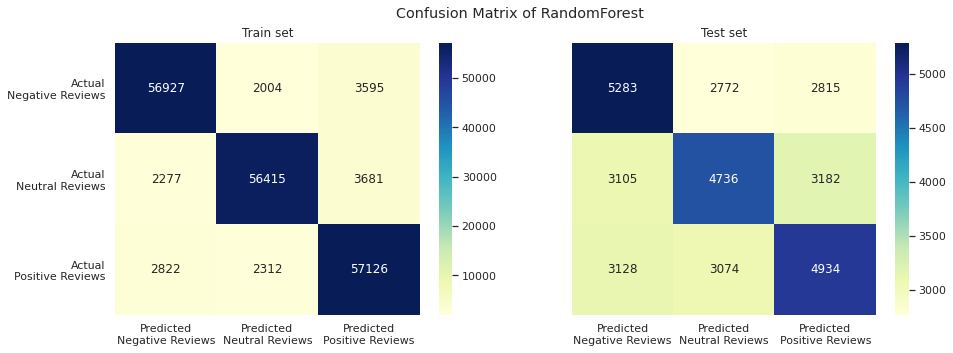

In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix_train = confusion_matrix(y_train_base, best_model.predict(X_train_base))
conf_matrix_test = confusion_matrix(y_test_base, best_model.predict(X_test_base))

index = ["Actual\nNegative Reviews", "Actual\nNeutral Reviews", "Actual\nPositive Reviews"]
columns = ["Predicted\nNegative Reviews", "Predicted\nNeutral Reviews", "Predicted\nPositive Reviews"]

conf_matrix_train = pd.DataFrame(data=conf_matrix_train, columns=columns, index=index)
conf_matrix_test = pd.DataFrame(data=conf_matrix_test, columns=columns, index=index)

plt.figure(figsize=(15, 5))
plt.suptitle("Confusion Matrix of %s" % best_model_name)
ax1 = plt.subplot(1, 2, 1)
plt.yticks(range(3), ha="right")
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Train set")
ax2 = plt.subplot(1, 2, 2)
plt.setp(ax2.get_yticklabels(), visible=False)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Test set")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print("Classification report of %s on the train set" % (best_model_name))
print(classification_report(y_train_base, best_model.predict(X_train_base)))
print()
print("Classification report of %s on the test set" % (best_model_name))
print(classification_report(y_test_base, best_model.predict(X_test_base)))

Classification report of RandomForest on the train set
              precision    recall  f1-score   support

           0       0.92      0.91      0.91     62526
           1       0.93      0.90      0.92     62373
           2       0.89      0.92      0.90     62260

    accuracy                           0.91    187159
   macro avg       0.91      0.91      0.91    187159
weighted avg       0.91      0.91      0.91    187159


Classification report of RandomForest on the test set
              precision    recall  f1-score   support

           0       0.46      0.49      0.47     10870
           1       0.45      0.43      0.44     11023
           2       0.45      0.44      0.45     11136

    accuracy                           0.45     33029
   macro avg       0.45      0.45      0.45     33029
weighted avg       0.45      0.45      0.45     33029



# Bag of Words approach

For the models of this approach we will not use the grid search since it would be unfeasible to run multiple times the models with the amount of features we use. We will use the same manager we created for the grid search with just the pre-defined params in order to save the results in the same way.

In [ ]:
X_train["completeText"] = X_train["summary"].str.cat(X_train["reviewText"], sep=". ")
X_test["completeText"] = X_test["summary"].str.cat(X_test["reviewText"], sep=". ")

X_train["completeText"].head(10)

71137     One Star. Creates weird reflection on my image...
60608     Shoddy & unreliable--died for no reason after ...
98962     it was a nice mouse. Died after one year. When...
186651    Durable and protects your HD. This was one of ...
43350     Very Poor Construction. The issues I had with ...
197673    My best friend!. This DVD player has changed m...
60248     Expiring Date. I bought this film October 21, ...
181376               Good deal!. Great sound for the price.
204602    Perfect point and shoot camera but.... This ca...
76927                               Three Stars. Works fine
Name: completeText, dtype: object

In [ ]:
# Take the completeText
X_train_bow = X_train[["completeText"]]
y_train_bow = y_train
X_test_bow = X_test[["completeText"]]
y_test_bow = y_test

X_train_bow.head(10)

,completeText
71137,One Star. Creates weird reflection on my image...
60608,Shoddy & unreliable--died for no reason after ...
98962,it was a nice mouse. Died after one year. When...
186651,Durable and protects your HD. This was one of ...
43350,Very Poor Construction. The issues I had with ...
197673,My best friend!. This DVD player has changed m...
60248,"Expiring Date. I bought this film October 21, ..."
181376,Good deal!. Great sound for the price.
204602,Perfect point and shoot camera but.... This ca...
76927,Three Stars. Works fine


## Bag of Words representation

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

VOCABULARY_SIZE = 500

vectorizer = CountVectorizer(max_features=VOCABULARY_SIZE, binary=True)
train_bow_matrix = vectorizer.fit_transform(X_train_bow["completeText"])
test_bow_matrix = vectorizer.transform(X_test_bow["completeText"])

# Create grid search manager
ags_bow = AdvancedGridSearch(train_bow_matrix, y_train_bow, cv)

print("Vocabulary size:", len(vectorizer.get_feature_names()))

Vocabulary size: 500


### Only reviewText

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_name = "RandomForest [BoW]"
pipeline = make_pipeline(RandomForestClassifier(random_state=42, n_jobs=-1))

parameters = {"n_estimators": [50], "criterion": ["gini"], "max_depth": [50], "min_samples_leaf": [5]}
new_params = {"randomforestclassifier__" + key: parameters[key] for key in parameters}

ags_bow.fit(model_name, pipeline, new_params, show_results=True)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.9min finished

[RandomForest [BoW]] Grid search completed in 410.088 sec
[RandomForest [BoW]] Best params: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 50, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__n_estimators': 50}
[RandomForest [BoW]] Train Score: 0.863
[RandomForest [BoW]] Validate Score: 0.715



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__criterion,param_randomforestclassifier__max_depth,param_randomforestclassifier__min_samples_leaf,param_randomforestclassifier__n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,174.604,0.0,0.347,0.0,gini,50,5,50,"{'randomforestclassifier__criterion': 'gini', ...",0.715,0.715,0.0,1,0.863,0.863,0.0


In [ ]:
from sklearn.neural_network import MLPClassifier

model_name = "MultiLayerPerceptor [BoW]"
pipeline = make_pipeline(MLPClassifier(random_state=42))

parameters = {
    "hidden_layer_sizes": [(32)],
    "activation": ["relu"],
    "solver": ["adam"],
    "alpha": [0.001],
}
new_params = {"mlpclassifier__" + key: parameters[key] for key in parameters}

ags_bow.fit(model_name, pipeline, new_params, show_results=True)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.4min finished

[MultiLayerPerceptor [BoW]] Grid search completed in 577.541 sec
[MultiLayerPerceptor [BoW]] Best params: {'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.001, 'mlpclassifier__hidden_layer_sizes': 32, 'mlpclassifier__solver': 'adam'}
[MultiLayerPerceptor [BoW]] Train Score: 0.799
[MultiLayerPerceptor [BoW]] Validate Score: 0.708



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlpclassifier__activation,param_mlpclassifier__alpha,param_mlpclassifier__hidden_layer_sizes,param_mlpclassifier__solver,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,206.07,0.0,0.036,0.0,relu,0.001,32,adam,"{'mlpclassifier__activation': 'relu', 'mlpclas...",0.708,0.708,0.0,1,0.799,0.799,0.0


### All features

In [ ]:
import scipy.sparse as sp

# Add all the features to the text representation
features = X_train_base.values.astype(np.int32)
train_bow_features_matrix = sp.hstack([train_bow_matrix, features], format="csr")
features = X_test_base.values.astype(np.int32)
test_bow_features_matrix = sp.hstack([test_bow_matrix, features], format="csr")

ags_bow.set_X(train_bow_features_matrix)

train_bow_features_matrix.shape

(187159, 508)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_name = "RandomForest [BoW+features]"
pipeline = make_pipeline(RandomForestClassifier(random_state=42, n_jobs=-1))

parameters = {"n_estimators": [50], "criterion": ["gini"], "max_depth": [50], "min_samples_leaf": [5]}
new_params = {"randomforestclassifier__" + key: parameters[key] for key in parameters}

ags_bow.fit(model_name, pipeline, new_params, show_results=True)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.0min finished

[RandomForest [BoW+features]] Grid search completed in 415.512 sec
[RandomForest [BoW+features]] Best params: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 50, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__n_estimators': 50}
[RandomForest [BoW+features]] Train Score: 0.878
[RandomForest [BoW+features]] Validate Score: 0.714



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__criterion,param_randomforestclassifier__max_depth,param_randomforestclassifier__min_samples_leaf,param_randomforestclassifier__n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,176.439,0.0,0.31,0.0,gini,50,5,50,"{'randomforestclassifier__criterion': 'gini', ...",0.714,0.714,0.0,1,0.878,0.878,0.0


In [ ]:
from sklearn.neural_network import MLPClassifier

model_name = "MultiLayerPerceptor [BoW+features]"
pipeline = make_pipeline(MLPClassifier(random_state=42))

parameters = {
    "hidden_layer_sizes": [(32)],
    "activation": ["relu"],
    "solver": ["adam"],
    "alpha": [0.001],
}
new_params = {"mlpclassifier__" + key: parameters[key] for key in parameters}

ags_bow.fit(model_name, pipeline, new_params, show_results=True)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 10.8min finished

[MultiLayerPerceptor [BoW+features]] Grid search completed in 1340.839 sec
[MultiLayerPerceptor [BoW+features]] Best params: {'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.001, 'mlpclassifier__hidden_layer_sizes': 32, 'mlpclassifier__solver': 'adam'}
[MultiLayerPerceptor [BoW+features]] Train Score: 0.732
[MultiLayerPerceptor [BoW+features]] Validate Score: 0.719



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlpclassifier__activation,param_mlpclassifier__alpha,param_mlpclassifier__hidden_layer_sizes,param_mlpclassifier__solver,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,643.316,0.0,0.982,0.0,relu,0.001,32,adam,"{'mlpclassifier__activation': 'relu', 'mlpclas...",0.719,0.719,0.0,1,0.732,0.732,0.0


## Tf.idf representation

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

VOCABULARY_SIZE = 500

vectorizer = TfidfVectorizer(max_features=VOCABULARY_SIZE)
train_tfidf_matrix = vectorizer.fit_transform(X_train_bow["completeText"])
test_tfidf_matrix = vectorizer.transform(X_test_bow["completeText"])

# Set new train data to the grid search manager
ags_bow.set_X(train_tfidf_matrix)

print("Vocabulary size:", len(vectorizer.get_feature_names()))

Vocabulary size: 500


### Only reviewText

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_name = "RandomForest [TfIdf]"
pipeline = make_pipeline(RandomForestClassifier(random_state=42, n_jobs=-1))

parameters = {"n_estimators": [50], "criterion": ["gini"], "max_depth": [50], "min_samples_leaf": [5]}
new_params = {"randomforestclassifier__" + key: parameters[key] for key in parameters}

ags_bow.fit(model_name, pipeline, new_params, show_results=True)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.3min finished

[RandomForest [TfIdf]] Grid search completed in 453.404 sec
[RandomForest [TfIdf]] Best params: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 50, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__n_estimators': 50}
[RandomForest [TfIdf]] Train Score: 0.913
[RandomForest [TfIdf]] Validate Score: 0.727



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__criterion,param_randomforestclassifier__max_depth,param_randomforestclassifier__min_samples_leaf,param_randomforestclassifier__n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,193.557,0.0,0.441,0.0,gini,50,5,50,"{'randomforestclassifier__criterion': 'gini', ...",0.727,0.727,0.0,1,0.913,0.913,0.0


In [ ]:
from sklearn.neural_network import MLPClassifier

model_name = "MultiLayerPerceptor [TfIdf]"
pipeline = make_pipeline(MLPClassifier(random_state=42))

parameters = {
    "hidden_layer_sizes": [(32)],
    "activation": ["relu"],
    "solver": ["adam"],
    "alpha": [0.001],
}
new_params = {"mlpclassifier__" + key: parameters[key] for key in parameters}

ags_bow.fit(model_name, pipeline, new_params, show_results=True)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.3min finished

[MultiLayerPerceptor [TfIdf]] Grid search completed in 558.178 sec
[MultiLayerPerceptor [TfIdf]] Best params: {'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.001, 'mlpclassifier__hidden_layer_sizes': 32, 'mlpclassifier__solver': 'adam'}
[MultiLayerPerceptor [TfIdf]] Train Score: 0.800
[MultiLayerPerceptor [TfIdf]] Validate Score: 0.716



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlpclassifier__activation,param_mlpclassifier__alpha,param_mlpclassifier__hidden_layer_sizes,param_mlpclassifier__solver,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,200.424,0.0,0.034,0.0,relu,0.001,32,adam,"{'mlpclassifier__activation': 'relu', 'mlpclas...",0.716,0.716,0.0,1,0.8,0.8,0.0


### All features

In [ ]:
import scipy.sparse as sp

# Add all the features to the text representation
features = X_train_base.values.astype(np.int32)
train_tfidf_features_matrix = sp.hstack([train_tfidf_matrix, features], format="csr")
features = X_test_base.values.astype(np.int32)
test_tfidf_features_matrix = sp.hstack([test_tfidf_matrix, features], format="csr")

ags_bow.set_X(train_tfidf_features_matrix)

train_tfidf_features_matrix.shape

(187159, 508)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_name = "RandomForest [TfIdf+features]"
pipeline = make_pipeline(RandomForestClassifier(random_state=42, n_jobs=-1))

parameters = {"n_estimators": [50], "criterion": ["gini"], "max_depth": [50], "min_samples_leaf": [5]}
new_params = {"randomforestclassifier__" + key: parameters[key] for key in parameters}

ags_bow.fit(model_name, pipeline, new_params, show_results=True)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.5min finished

[RandomForest [TfIdf+features]] Grid search completed in 478.241 sec
[RandomForest [TfIdf+features]] Best params: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 50, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__n_estimators': 50}
[RandomForest [TfIdf+features]] Train Score: 0.919
[RandomForest [TfIdf+features]] Validate Score: 0.724



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__criterion,param_randomforestclassifier__max_depth,param_randomforestclassifier__min_samples_leaf,param_randomforestclassifier__n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,206.862,0.0,0.41,0.0,gini,50,5,50,"{'randomforestclassifier__criterion': 'gini', ...",0.724,0.724,0.0,1,0.919,0.919,0.0


In [ ]:
from sklearn.neural_network import MLPClassifier

model_name = "MultiLayerPerceptor [TfIdf+features]"
pipeline = make_pipeline(MLPClassifier(random_state=42))

parameters = {
    "hidden_layer_sizes": [(32)],
    "activation": ["relu"],
    "solver": ["adam"],
    "alpha": [0.001],
}
new_params = {"mlpclassifier__" + key: parameters[key] for key in parameters}

ags_bow.fit(model_name, pipeline, new_params, show_results=True)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.8min finished

[MultiLayerPerceptor [TfIdf+features]] Grid search completed in 497.521 sec
[MultiLayerPerceptor [TfIdf+features]] Best params: {'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.001, 'mlpclassifier__hidden_layer_sizes': 32, 'mlpclassifier__solver': 'adam'}
[MultiLayerPerceptor [TfIdf+features]] Train Score: 0.726
[MultiLayerPerceptor [TfIdf+features]] Validate Score: 0.720



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlpclassifier__activation,param_mlpclassifier__alpha,param_mlpclassifier__hidden_layer_sizes,param_mlpclassifier__solver,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,164.288,0.0,0.514,0.0,relu,0.001,32,adam,"{'mlpclassifier__activation': 'relu', 'mlpclas...",0.72,0.72,0.0,1,0.726,0.726,0.0


## Testing and Evaluation

In [ ]:
columns = ["Train Accuracy score", "Validate Accuracy score"]
df_scores = pd.DataFrame(ags_bow.scores.values(), index=ags_bow.scores.keys(), columns=columns)
df_scores = df_scores.sort_values("Validate Accuracy score", ascending=False)
df_scores

,Train Accuracy score,Validate Accuracy score
RandomForest [TfIdf],0.912998,0.726978
RandomForest [TfIdf+features],0.919455,0.724181
MultiLayerPerceptor [TfIdf+features],0.725662,0.719593
MultiLayerPerceptor [BoW+features],0.731616,0.719121
MultiLayerPerceptor [TfIdf],0.799621,0.715633
RandomForest [BoW],0.863030,0.714847
RandomForest [BoW+features],0.878126,0.714470
MultiLayerPerceptor [BoW],0.798733,0.708247


In [ ]:
max_score = df_scores["Validate Accuracy score"].max()
best_model_name = df_scores[df_scores["Validate Accuracy score"] == max_score].index[0]
best_model = ags_bow.models[best_model_name]
print("The best model is the {} with {} of accuracy on the validation set".format(best_model_name, round(max_score, 3)))

The best model is the RandomForest [TfIdf] with 0.727 of accuracy on the validation set


In [ ]:
# Take right training data
if "[TfIdf]" in best_model_name:
  train_matrix = train_tfidf_matrix
elif "[TfIdf+features]" in best_model_name:
  train_matrix = train_tfidf_features_matrix
elif "[Bow]" in best_model_name:
  train_matrix = train_bow_matrix
else:
  train_matrix = train_bow_features_matrix

# Take right testing data
if "[TfIdf]" in best_model_name:
  test_matrix = test_tfidf_matrix
elif "[TfIdf+features]" in best_model_name:
  test_matrix = test_tfidf_features_matrix
elif "[Bow]" in best_model_name:
  test_matrix = test_bow_matrix
else:
  test_matrix = test_bow_features_matrix

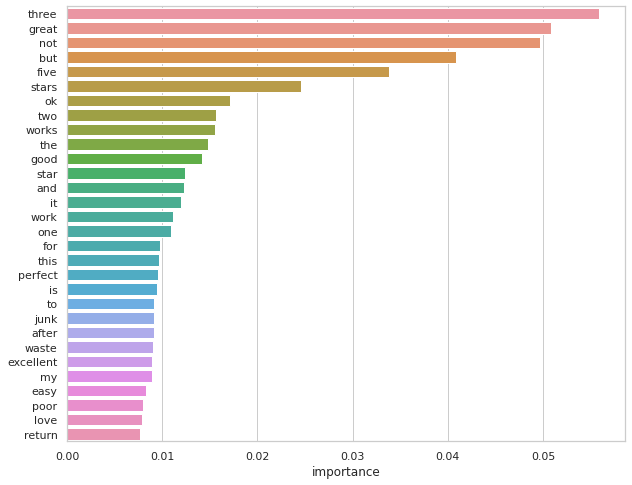

In [ ]:
if train_matrix.shape[1] == 500:
  features = vectorizer.get_feature_names()
else:
  features = np.hstack([vectorizer.get_feature_names(), X_train_base.columns])
importances = pd.DataFrame(np.zeros((train_matrix.shape[1], 1)), columns=["importance"], index=features)

rfc = best_model.named_steps["randomforestclassifier"]
importances.iloc[:,0] = rfc.feature_importances_

importances = importances.sort_values(by="importance", ascending=False)[:30]

plt.figure(figsize=(10, 8))
sns.barplot(x="importance", y=importances.index, data=importances)
plt.show()

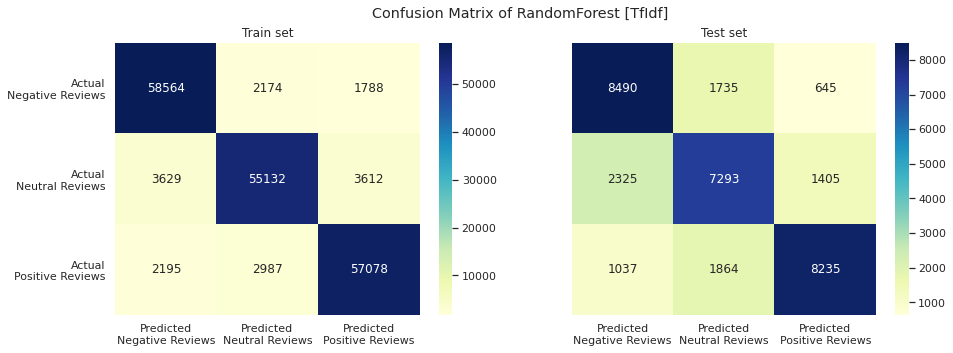

In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix_train = confusion_matrix(y_train_bow, best_model.predict(train_matrix))
conf_matrix_test = confusion_matrix(y_test_bow, best_model.predict(test_matrix))

index = ["Actual\nNegative Reviews", "Actual\nNeutral Reviews", "Actual\nPositive Reviews"]
columns = ["Predicted\nNegative Reviews", "Predicted\nNeutral Reviews", "Predicted\nPositive Reviews"]

conf_matrix_train = pd.DataFrame(data=conf_matrix_train, columns=columns, index=index)
conf_matrix_test = pd.DataFrame(data=conf_matrix_test, columns=columns, index=index)

plt.figure(figsize=(15, 5))
plt.suptitle("Confusion Matrix of %s" % best_model_name)
ax1 = plt.subplot(1, 2, 1)
plt.yticks(range(3), ha="right")
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Train set")
ax2 = plt.subplot(1, 2, 2)
plt.setp(ax2.get_yticklabels(), visible=False)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Test set")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print("Classification report of %s on the train set" % (best_model_name))
print(classification_report(y_train_bow, best_model.predict(train_matrix)))
print()
print("Classification report of %s on the test set" % (best_model_name))
print(classification_report(y_test_bow, best_model.predict(test_matrix)))

Classification report of RandomForest [TfIdf] on the train set
              precision    recall  f1-score   support

           0       0.91      0.94      0.92     62526
           1       0.91      0.88      0.90     62373
           2       0.91      0.92      0.92     62260

    accuracy                           0.91    187159
   macro avg       0.91      0.91      0.91    187159
weighted avg       0.91      0.91      0.91    187159


Classification report of RandomForest [TfIdf] on the test set
              precision    recall  f1-score   support

           0       0.72      0.78      0.75     10870
           1       0.67      0.66      0.67     11023
           2       0.80      0.74      0.77     11136

    accuracy                           0.73     33029
   macro avg       0.73      0.73      0.73     33029
weighted avg       0.73      0.73      0.73     33029



# Embeddings approach

In [ ]:
X_train["completeText"] = X_train["summary"].str.cat(X_train["reviewText"], sep=". ")
X_test["completeText"] = X_test["summary"].str.cat(X_test["reviewText"], sep=". ")

X_train["completeText"].head(10)

71137     One Star. Creates weird reflection on my image...
60608     Shoddy & unreliable--died for no reason after ...
98962     it was a nice mouse. Died after one year. When...
186651    Durable and protects your HD. This was one of ...
43350     Very Poor Construction. The issues I had with ...
197673    My best friend!. This DVD player has changed m...
60248     Expiring Date. I bought this film October 21, ...
181376               Good deal!. Great sound for the price.
204602    Perfect point and shoot camera but.... This ca...
76927                               Three Stars. Works fine
Name: completeText, dtype: object

In [ ]:
# Take the completeText
X_train_emb = X_train[["completeText"]]
y_train_emb = y_train
X_test_emb = X_test[["completeText"]]
y_test_emb = y_test

X_train_emb.head(10)

,completeText
71137,One Star. Creates weird reflection on my image...
60608,Shoddy & unreliable--died for no reason after ...
98962,it was a nice mouse. Died after one year. When...
186651,Durable and protects your HD. This was one of ...
43350,Very Poor Construction. The issues I had with ...
197673,My best friend!. This DVD player has changed m...
60248,"Expiring Date. I bought this film October 21, ..."
181376,Good deal!. Great sound for the price.
204602,Perfect point and shoot camera but.... This ca...
76927,Three Stars. Works fine


In [ ]:
import tensorflow as tf

In [ ]:
#@title Download GloVe
from google_drive_downloader import GoogleDriveDownloader as gdd
import os

if not os.path.isfile("/content/glove.6B.100d.txt"):
  gdd.download_file_from_google_drive(file_id="1Hnpuyj4p_XhvSA2LSDmRHXXDx5W6px-P", dest_path="/content/glove.6B.100d.zip", unzip=True)
else:
  print("GloVe alreay downloaded.")

Unzipping...Done.


In [ ]:
#@title Read GloVe

embeddings_index = {}

with open("glove.6B.100d.txt") as f:
  start = time.time()
  lines = f.readlines()

  size = len(lines)

  for i, line in enumerate(lines):
      values = line.split()
      word = values[0]
      coeffs = np.asarray(values[1:], dtype=np.float32)
      embeddings_index[word] = coeffs

      # Progress bar
      if i % 100 == 0:
        progress_bar = get_progress_bar(i, size)
        percent = int(i/size * 100)
        print("\r%s%% %s Loading..." % (percent, progress_bar), end="")
  
  strtime = datetime.fromtimestamp(time.time() - start).strftime("%Mm %Ss")
  print("\r100%% %s Loaded %s word vectors in %s" % (get_progress_bar(size, size), len(embeddings_index), strtime))

100% [====================] Loaded 400000 word vectors in 00m 13s


In [ ]:
EMBEDDING_DIM = 100 #@param
MAX_SEQUENCE_LENGTH = 1000 #@param
MAX_NUM_WORDS = 2048 #@param

## Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, lower=True)
tokenizer.fit_on_texts(X_train_emb["completeText"])
train_sequences = tokenizer.texts_to_sequences(X_train_emb["completeText"])
test_sequences = tokenizer.texts_to_sequences(X_test_emb["completeText"])

word_index = tokenizer.word_index
print("Found %s unique tokens" % len(word_index))

Found 103820 unique tokens


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print("Created embedding matrix from GloVe embeddings")

Created embedding matrix from GloVe embeddings


In [ ]:
from keras.preprocessing.sequence import pad_sequences

X_train_emb = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test_emb = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

y_train_emb = np.array(y_train_emb)
y_test_emb = np.array(y_test_emb)

print("Train + Validate size:", X_train_emb.shape, y_train_emb.shape)
print("Test size:", X_test_emb.shape, y_test_emb.shape)

Train + Validate size: (187159, 1000) (187159,)
Test size: (33029, 1000) (33029,)


## Base Model

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D

base_model = Sequential([
  Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH),
  SpatialDropout1D(.2),
  Conv1D(512, 3, activation="relu"),
  MaxPooling1D(2),
  Conv1D(256, 3, activation="relu"),
  MaxPooling1D(2),
  Conv1D(128, 3, activation="relu"),
  GlobalMaxPooling1D(),
  Dense(128, activation="relu"),
  Dense(3, activation="softmax")
])

base_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         10382100  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1000, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 998, 512)          154112    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 499, 512)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 497, 256)          393472    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 248, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 246, 128)          9

In [ ]:
base_history = base_model.fit(X_train_emb, y_train_emb, epochs=10, batch_size=128, validation_split=.2, shuffle=True)

Epoch 1/10
1170/1170 [==============================] - 292s 222ms/step - loss: 0.6255 - accuracy: 0.7168 - val_loss: 0.5192 - val_accuracy: 0.7742
Epoch 2/10
1170/1170 [==============================] - 259s 221ms/step - loss: 0.5119 - accuracy: 0.7804 - val_loss: 0.4957 - val_accuracy: 0.7868
Epoch 3/10
1170/1170 [==============================] - 258s 220ms/step - loss: 0.4781 - accuracy: 0.7953 - val_loss: 0.4888 - val_accuracy: 0.7906
Epoch 4/10
1170/1170 [==============================] - 258s 220ms/step - loss: 0.4512 - accuracy: 0.8086 - val_loss: 0.4853 - val_accuracy: 0.7923
Epoch 5/10
1170/1170 [==============================] - 256s 219ms/step - loss: 0.4243 - accuracy: 0.8207 - val_loss: 0.4848 - val_accuracy: 0.7941
Epoch 6/10
1170/1170 [==============================] - 257s 220ms/step - loss: 0.3994 - accuracy: 0.8319 - val_loss: 0.4863 - val_accuracy: 0.7951
Epoch 7/10
1170/1170 [==============================] - 257s 220ms/step - loss: 0.3744 - accuracy: 0.8443 - val_

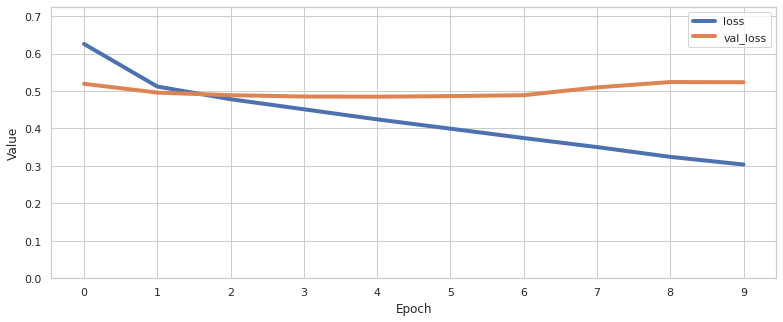

In [ ]:
N = range(len(base_history.history["loss"]))
plt.figure(figsize=(13, 5))
plt.plot(N, base_history.history["loss"], label="loss", linewidth=4)
plt.plot(N, base_history.history["val_loss"], label="val_loss", linewidth=4)
plt.xticks(N)
plt.ylim(0, max(max(base_history.history["loss"]), max(base_history.history["val_loss"])) + .1)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend(loc="best")
plt.show()

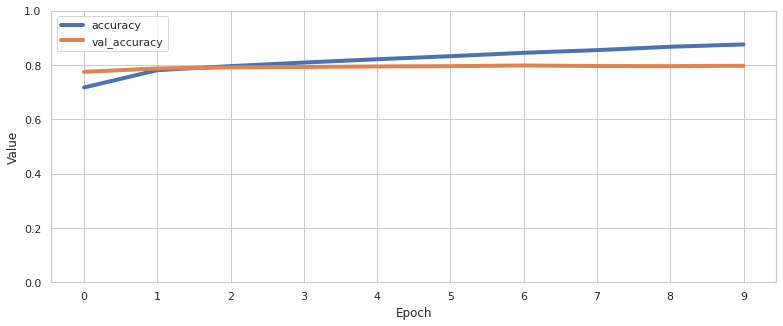

In [ ]:
N = range(len(base_history.history["accuracy"]))
plt.figure(figsize=(13, 5))
plt.plot(N, base_history.history["accuracy"], label="accuracy", linewidth=4)
plt.plot(N, base_history.history["val_accuracy"], label="val_accuracy", linewidth=4)
plt.xticks(N)
plt.ylim(0, 1)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend(loc="best")
plt.show()

In [ ]:
base_model.save("models/cnn.h5")

## LSTM Model

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM

lstm_model = Sequential([
  Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH),
  LSTM(128, dropout=.2),
  Dense(128, activation="relu"),
  Dense(3, activation="softmax")
])

lstm_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         10382100  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 10,516,247
Trainable params: 10,516,247
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_history = lstm_model.fit(X_train_emb, y_train_emb, epochs=10, batch_size=128, validation_split=.2, shuffle=True)

Epoch 1/10
1170/1170 [==============================] - 221s 186ms/step - loss: 0.6820 - accuracy: 0.6894 - val_loss: 0.5430 - val_accuracy: 0.7678
Epoch 2/10
1170/1170 [==============================] - 216s 185ms/step - loss: 0.5179 - accuracy: 0.7765 - val_loss: 0.5248 - val_accuracy: 0.7739
Epoch 3/10
1170/1170 [==============================] - 216s 185ms/step - loss: 0.4852 - accuracy: 0.7925 - val_loss: 0.4828 - val_accuracy: 0.7938
Epoch 4/10
1170/1170 [==============================] - 217s 185ms/step - loss: 0.4648 - accuracy: 0.8011 - val_loss: 0.4772 - val_accuracy: 0.7962
Epoch 5/10
1170/1170 [==============================] - 216s 185ms/step - loss: 0.4460 - accuracy: 0.8094 - val_loss: 0.4687 - val_accuracy: 0.7996
Epoch 6/10
1170/1170 [==============================] - 216s 184ms/step - loss: 0.4291 - accuracy: 0.8173 - val_loss: 0.4650 - val_accuracy: 0.8023
Epoch 7/10
1170/1170 [==============================] - 216s 184ms/step - loss: 0.4124 - accuracy: 0.8254 - val_

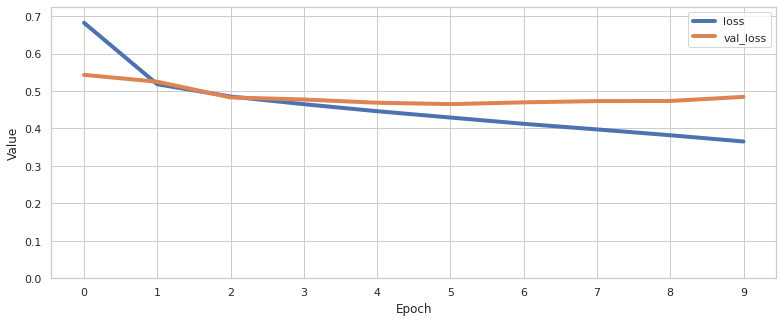

In [ ]:
N = range(len(lstm_history.history["loss"]))
plt.figure(figsize=(13, 5))
plt.plot(N, lstm_history.history["loss"], label="loss", linewidth=4)
plt.plot(N, lstm_history.history["val_loss"], label="val_loss", linewidth=4)
plt.xticks(N)
plt.ylim(0, max(max(base_history.history["loss"]), max(base_history.history["val_loss"])) + .1)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend(loc="best")
plt.show()

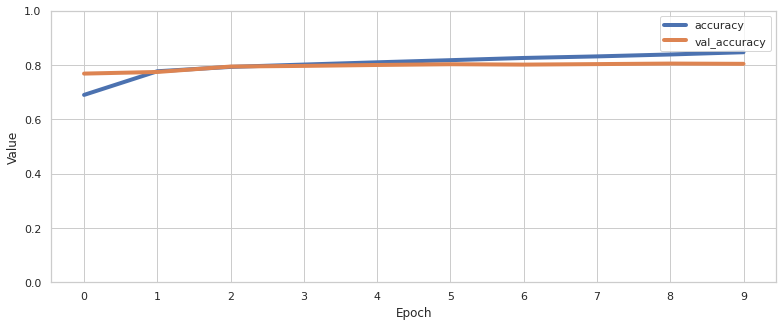

In [ ]:
N = range(len(lstm_history.history["accuracy"]))
plt.figure(figsize=(13, 5))
plt.plot(N, lstm_history.history["accuracy"], label="accuracy", linewidth=4)
plt.plot(N, lstm_history.history["val_accuracy"], label="val_accuracy", linewidth=4)
plt.xticks(N)
plt.ylim(0, 1)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend(loc="best")
plt.show()

In [ ]:
lstm_model.save("models/lstm.h5")

## Testing Base model

In [ ]:
base_model_results = base_model.evaluate(X_test_emb, y_test_emb, batch_size=128)
print("Base model loss:", base_model_results[0])
print("Base model accuracy:", base_model_results[1])

259/259 [==============================] - 13s 51ms/step - loss: 0.5193 - accuracy: 0.7960
Base model loss: 0.5193166136741638
Base model accuracy: 0.7960277199745178


In [ ]:
y_train_pred = base_model.predict(X_train_emb)
y_test_pred = base_model.predict(X_test_emb)

y_train_pred_argmax = np.argmax(y_train_pred, axis=-1)
y_test_pred_argmax = np.argmax(y_test_pred, axis=-1)

y_train_pred_argmax.shape, y_test_pred_argmax.shape

((187159,), (33029,))

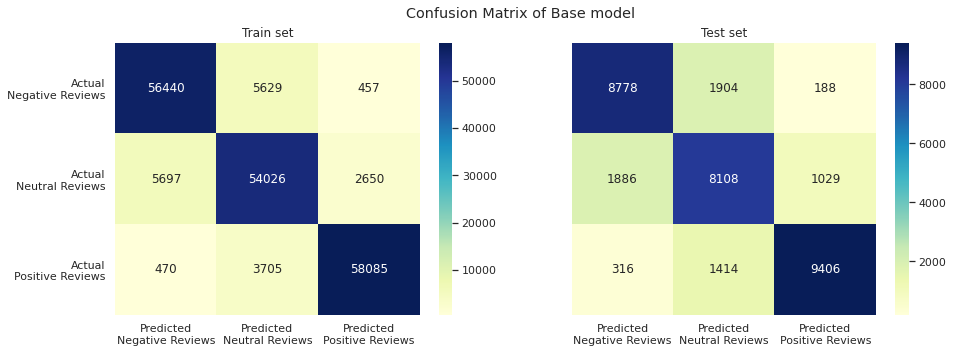

In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix_train = confusion_matrix(y_train_emb, y_train_pred_argmax)
conf_matrix_test = confusion_matrix(y_test_emb, y_test_pred_argmax)

index = ["Actual\nNegative Reviews", "Actual\nNeutral Reviews", "Actual\nPositive Reviews"]
columns = ["Predicted\nNegative Reviews", "Predicted\nNeutral Reviews", "Predicted\nPositive Reviews"]

conf_matrix_train = pd.DataFrame(data=conf_matrix_train, columns=columns, index=index)
conf_matrix_test = pd.DataFrame(data=conf_matrix_test, columns=columns, index=index)

plt.figure(figsize=(15, 5))
plt.suptitle("Confusion Matrix of Base model")
ax1 = plt.subplot(1, 2, 1)
plt.yticks(range(3), ha="right")
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Train set")
ax2 = plt.subplot(1, 2, 2)
plt.setp(ax2.get_yticklabels(), visible=False)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Test set")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print("Classification report of Base model on the train set")
print(classification_report(y_train_emb, y_train_pred_argmax))
print()
print("Classification report of Base model on the test set")
print(classification_report(y_test_emb, y_test_pred_argmax))

Classification report of Base model on the train set
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     62526
           1       0.85      0.87      0.86     62373
           2       0.95      0.93      0.94     62260

    accuracy                           0.90    187159
   macro avg       0.90      0.90      0.90    187159
weighted avg       0.90      0.90      0.90    187159


Classification report of Base model on the test set
              precision    recall  f1-score   support

           0       0.80      0.81      0.80     10870
           1       0.71      0.74      0.72     11023
           2       0.89      0.84      0.86     11136

    accuracy                           0.80     33029
   macro avg       0.80      0.80      0.80     33029
weighted avg       0.80      0.80      0.80     33029



## Testing LSTM model

In [ ]:
lstm_model_results = lstm_model.evaluate(X_test_emb, y_test_emb, batch_size=128)
print("LSTM model loss:", lstm_model_results[0])
print("LSTM model accuracy:", lstm_model_results[1])

259/259 [==============================] - 9s 36ms/step - loss: 0.4718 - accuracy: 0.8097
LSTM model loss: 0.47180047631263733
LSTM model accuracy: 0.8096521496772766


In [ ]:
y_train_pred = lstm_model.predict(X_train_emb)
y_test_pred = lstm_model.predict(X_test_emb)

y_train_pred_argmax = np.argmax(y_train_pred, axis=-1)
y_test_pred_argmax = np.argmax(y_test_pred, axis=-1)

y_train_pred_argmax.shape, y_test_pred_argmax.shape

((187159,), (33029,))

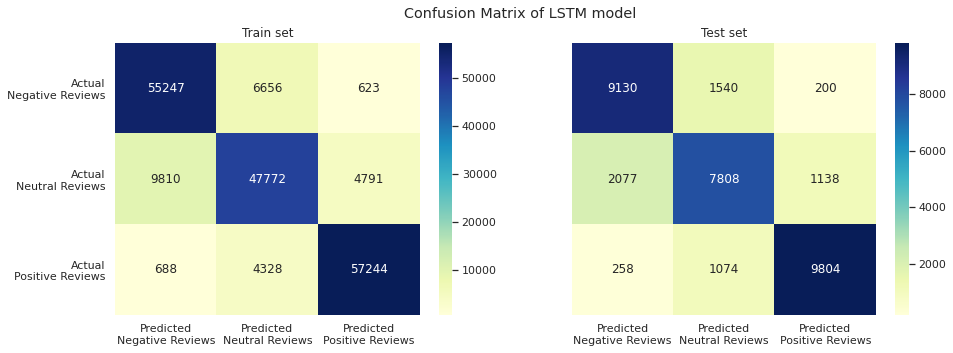

In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix_train = confusion_matrix(y_train_emb, y_train_pred_argmax)
conf_matrix_test = confusion_matrix(y_test_emb, y_test_pred_argmax)

index = ["Actual\nNegative Reviews", "Actual\nNeutral Reviews", "Actual\nPositive Reviews"]
columns = ["Predicted\nNegative Reviews", "Predicted\nNeutral Reviews", "Predicted\nPositive Reviews"]

conf_matrix_train = pd.DataFrame(data=conf_matrix_train, columns=columns, index=index)
conf_matrix_test = pd.DataFrame(data=conf_matrix_test, columns=columns, index=index)

plt.figure(figsize=(15, 5))
plt.suptitle("Confusion Matrix of LSTM model")
ax1 = plt.subplot(1, 2, 1)
plt.yticks(range(3), ha="right")
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Train set")
ax2 = plt.subplot(1, 2, 2)
plt.setp(ax2.get_yticklabels(), visible=False)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Test set")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print("Classification report of LSTM model on the train set")
print(classification_report(y_train_emb, y_train_pred_argmax))
print()
print("Classification report of LSTM model on the test set")
print(classification_report(y_test_emb, y_test_pred_argmax))

Classification report of LSTM model on the train set
              precision    recall  f1-score   support

           0       0.84      0.88      0.86     62526
           1       0.81      0.77      0.79     62373
           2       0.91      0.92      0.92     62260

    accuracy                           0.86    187159
   macro avg       0.86      0.86      0.86    187159
weighted avg       0.86      0.86      0.86    187159


Classification report of LSTM model on the test set
              precision    recall  f1-score   support

           0       0.80      0.84      0.82     10870
           1       0.75      0.71      0.73     11023
           2       0.88      0.88      0.88     11136

    accuracy                           0.81     33029
   macro avg       0.81      0.81      0.81     33029
weighted avg       0.81      0.81      0.81     33029



## Real review testing

In [ ]:
from tensorflow.keras.models import load_model

base_model = load_model("models/cnn.h5")
lstm_model = load_model("models/lstm.h5")

In [ ]:
text = r"Epson 2150 projector - great image but noisy. Out of the box the picture is great when projected on a living room wall. The remote is a joke - looks like a toy for a 5 year old. Fan is loud unless you turn on the eco mode. It also made a lot of noise. Not sure but probabily the iris. It's been four weeks and I still have not received my refund from Amazon!"
sequences = tokenizer.texts_to_sequences([text])
print("Text:", text)
print("Sequence:", sequences[0])
print("Reconverted:", tokenizer.sequences_to_texts(sequences=sequences[0:1]))
print()

padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print("Base model predicted:", np.argmax(base_model.predict(padded_sequences)))
print("LSTM model predicted:", np.argmax(lstm_model.predict(padded_sequences)))

Text: Epson 2150 projector - great image but noisy. Out of the box the picture is great when projected on a living room wall. The remote is a joke - looks like a toy for a 5 year old. Fan is loud unless you turn on the eco mode. It also made a lot of noise. Not sure but probabily the iris. It's been four weeks and I still have not received my refund from Amazon!
Sequence: [1514, 32, 410, 17, 1353, 41, 8, 1, 208, 1, 232, 7, 32, 37, 18, 4, 1480, 343, 378, 1, 234, 7, 4, 319, 49, 4, 9, 4, 119, 236, 183, 523, 7, 459, 480, 16, 302, 18, 1, 467, 6, 83, 159, 4, 196, 8, 259, 14, 195, 17, 1, 48, 117, 505, 472, 5, 2, 105, 19, 14, 383, 13, 930, 35, 152]
Reconverted: ["projector great image but noisy out of the box the picture is great when on a living room wall the remote is a looks like a for a 5 year old fan is loud unless you turn on the mode it also made a lot of noise not sure but the it's been four weeks and i still have not received my refund from amazon"]

Base model predicted: 1
LSTM model

In [ ]:
text = r"Very good product. This headset is light weight and has very good quality sound for the price and is very comfortable. Microphone works good as well. Lights on the sides of the headset make it look nice. Only complaint is that this headset is meant for PC users given the fact that both the USB cable and microphone plug in are connected very close together to the cable. Meaning, that if you are playing on PS4 you plug the microphone cable into the controller but can't plug the USB cable into the system for the lights. I ended up buying a 3 foot USB extension cable in order to be able to use the lights. So if you are using anything other than a PC and want the lights on the headset while you play, then you'll need an USB extension cable. This product is very good though. Very happy with the purchase"
sequences = tokenizer.texts_to_sequences([text])
print("Text:", text)
print("Sequence:", sequences[0])
print("Reconverted:", tokenizer.sequences_to_texts(sequences=sequences[0:1]))
print()

padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print("Base model predicted:", np.argmax(base_model.predict(padded_sequences)))
print("LSTM model predicted:", np.argmax(lstm_model.predict(padded_sequences)))

Text: Very good product. This headset is light weight and has very good quality sound for the price and is very comfortable. Microphone works good as well. Lights on the sides of the headset make it look nice. Only complaint is that this headset is meant for PC users given the fact that both the USB cable and microphone plug in are connected very close together to the cable. Meaning, that if you are playing on PS4 you plug the microphone cable into the controller but can't plug the USB cable into the system for the lights. I ended up buying a 3 foot USB extension cable in order to be able to use the lights. So if you are using anything other than a PC and want the lights on the headset while you play, then you'll need an USB extension cable. This product is very good though. Very happy with the purchase
Sequence: [31, 27, 54, 10, 485, 7, 178, 614, 5, 59, 31, 27, 58, 62, 9, 1, 75, 5, 7, 31, 431, 904, 56, 27, 21, 61, 987, 18, 1, 1499, 8, 1, 485, 143, 6, 226, 120, 53, 1116, 7, 12, 10, 485